In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/DataIntelligenceApplications/')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.standard_generator import StandardDataGenerator
from environments.complete_environment import CompleteEnvironment
from learners.joint_learner import JointLearner

In [3]:
src = 'src/basic005.json'

In [4]:
dg = StandardDataGenerator(src)

In [5]:
T = 365
n_experiments = 5
learners_to_test = [JointLearner]
rewards_per_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []

In [8]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'\n\nrunning experiment {e + 1}/{n_experiments}...')
    test_instances = []
    
    for learner in learners_to_test:
        #context_learner = ContextualLearner(features, learner, **bandit_args)
        test_instances.append(
            (learner(dg.get_margins(), dg.get_bids()),
             CompleteEnvironment(src=src))
        )
    for t in range(T):
        for learner, env in test_instances:
            #print(f'##### DAY {t} ######')
            learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            month_purchases = env.get_next_purchases_at_day(t, keep=False, filter_purchases=True)
            if month_purchases is not None:
                for arm, n_purchases in zip(past_arms, month_purchases):
                    learner.update_single_future_purchase(arm, n_purchases)

            pulled_bid, pulled_price = learner.pull_arm()
            daily_reward = env.day_round(pulled_price, pulled_bid, fixed_adv=False)
            for outcome, cost in daily_reward:
                learner.update(pulled_price, outcome, cost)
    for learner, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.LEARNER_NAME].append(learner.get_collected_reward())
# end -> save rhe results.



running experiment 1/5...


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)




running experiment 2/5...


running experiment 3/5...


running experiment 4/5...


running experiment 5/5...


In [10]:
#NEW!
dg = StandardDataGenerator(src)
print('src:\t',dg.get_source())
print('\nbid\tglobal\t\tr_aggr\t\t\tdelta')
aggr_arr = []
disaggr_arr = []
for j, bid in enumerate(dg.get_bids()):
    maxs=[]
    f_cost = dg.get_costs_per_click(mode='aggregate', bid=j)[j]
    clicks = dg.get_daily_clicks(mode='aggregate')[j]
    conv = dg.get_conversion_rates()
    fp = dg.get_future_purchases()
    for i in range(len(dg.get_classes())):
        maxs.append(np.max((conv[i] *(1 + fp[i]) * dg.get_margins() - dg.get_costs_per_click()[i,j]) * dg.get_daily_clicks()[i, j]))
    
    temp = (dg.get_margins() * np.average(conv * (1 + fp), axis=0, weights=dg.get_class_distributions(bid=j)) - 
        f_cost) * clicks
    
    #disaggr_arr.append(sum(maxs))
    aggr_arr.append(np.max(temp))
    disaggr = np.around(sum(maxs), decimals=4)
    aggr = np.around(np.max(temp), decimals=4)
    delta = np.around(disaggr-aggr, decimals=4)
    print(f'{j}\t{disaggr}\t{aggr}\t-->\t{delta}')
opt_aggr = max(aggr_arr)
opt_bid = np.argmax(aggr_arr)
print(f'\n{opt_aggr} - {opt_bid}')

src:	 src/basic005.json

bid	global		r_aggr			delta
0	1081.9945	1046.957	-->	35.0375
1	1109.2122	1071.8745	-->	37.3377
2	1122.3881	1083.0058	-->	39.3823
3	1121.4206	1079.0311	-->	42.3895
4	1099.1524	1054.3324	-->	44.82
5	1045.4969	997.8641	-->	47.6328
6	979.6053	929.8629	-->	49.7424
7	932.1964	881.4119	-->	50.7845
8	808.208	754.7065	-->	53.5015
9	680.911	626.6326	-->	54.2784

1083.005829407839 - 2


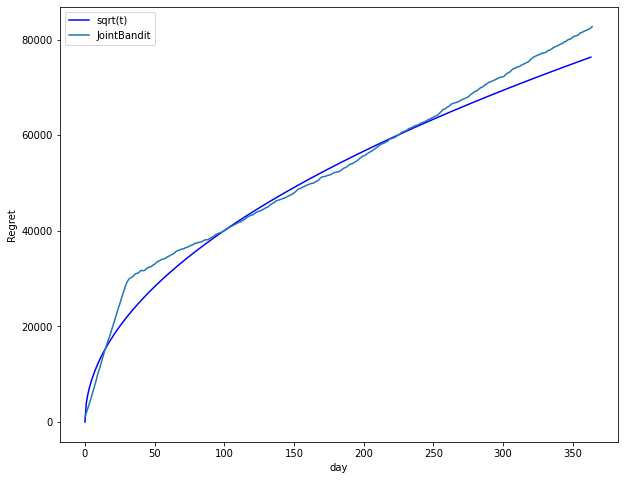

In [17]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")

plt.plot(4000*np.sqrt(np.linspace(0,364,364)), 'b')
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(opt_aggr - val, axis=0)))

plt.legend(['sqrt(t)'] + list(rewards_per_experiment.keys()))
plt.show()

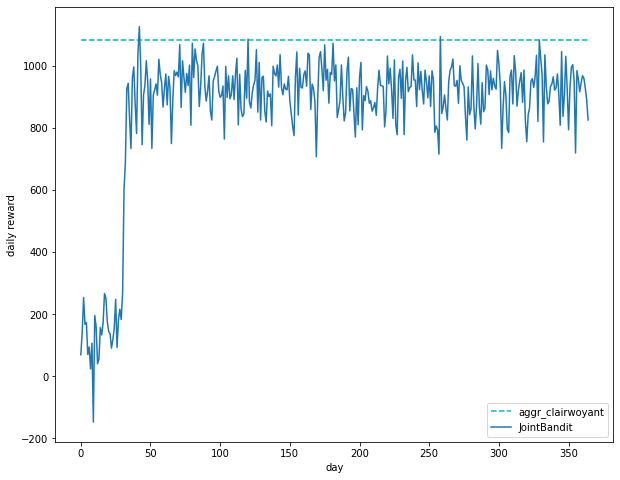

In [12]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
# plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([opt_aggr]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

plt.legend(loc='best')
plt.show()